In [5]:
from argparse import Namespace
config = Namespace(
    seq_len = 128,
    n_input_values = 4,
    mask_token = 0,
    mask_frac = 0.15,
    train_size = 100,
    val_size = 100,
    bs_train = 2,
    bs_val = 2,
)

In [6]:
from data.mirror_seq import theDataset
train_ds = theDataset(config, config.train_size)
val_ds = theDataset(config, config.val_size)
from trainer.pl_data import data_wrapper
pl_data = data_wrapper(config, train_ds, val_ds)
val_loader = pl_data.val_dataloader()

# show a batch
batch = next(iter(val_loader))
print(batch)

{'pos_id': tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127],
        [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  4

In [7]:
# Verification checks
import torch
def verify_data(batch):
    print("Verification Results:")
    
    # Check shapes
    print(f"\nShapes:")
    for key, value in batch.items():
        print(f"{key}: {value.shape}")
    
    # print fraction of masked positions
    print(f'Fraction of masked positions: {torch.sum(batch["mask"]) / batch["mask"].numel()}')

    # Verify mask positions match mask_token in input
    print(f'\nConsistency:')
    mask_matches = torch.all((batch['mask'] == 1) == (batch['input'] == config.mask_token))
    print(f"Mask positions match mask_token in input: {mask_matches}")
    
    # Verify non-masked positions match between input and target
    non_masked_match = torch.all(
        batch['input'] * (1 - batch['mask'].int()) == 
        batch['target'] * (1 - batch['mask'].int())
    )
    print(f"Non-masked positions match between input and target: {non_masked_match}")
    
    # Check if values are within expected range
    input_range = (batch['input'].min(), batch['input'].max())
    target_range = (batch['target'].min(), batch['target'].max())
    print(f"\nValue ranges:")
    print(f"Input values range: {input_range}")
    print(f"Target values range: {target_range}")
    
    # check dtype
    print(f'\nDtype:')
    print(f"Input dtype: {batch['input'].dtype}")
    print(f"Target dtype: {batch['target'].dtype}")
    print(f"Mask dtype: {batch['mask'].dtype}")
    print(f"Pos ID dtype: {batch['pos_id'].dtype}")

verify_data(batch)

Verification Results:

Shapes:
pos_id: torch.Size([2, 128])
input: torch.Size([2, 128])
target: torch.Size([2, 128])
mask: torch.Size([2, 128])
Fraction of masked positions: 0.1640625

Consistency:
Mask positions match mask_token in input: True
Non-masked positions match between input and target: True

Value ranges:
Input values range: (tensor(0), tensor(3))
Target values range: (tensor(1), tensor(3))

Dtype:
Input dtype: torch.int64
Target dtype: torch.int64
Mask dtype: torch.bool
Pos ID dtype: torch.int64


Saved batch masking visualization to batch_masking_visualization.png


<module 'matplotlib.pyplot' from '/home/augix/miniconda3/envs/snp/lib/python3.11/site-packages/matplotlib/pyplot.py'>

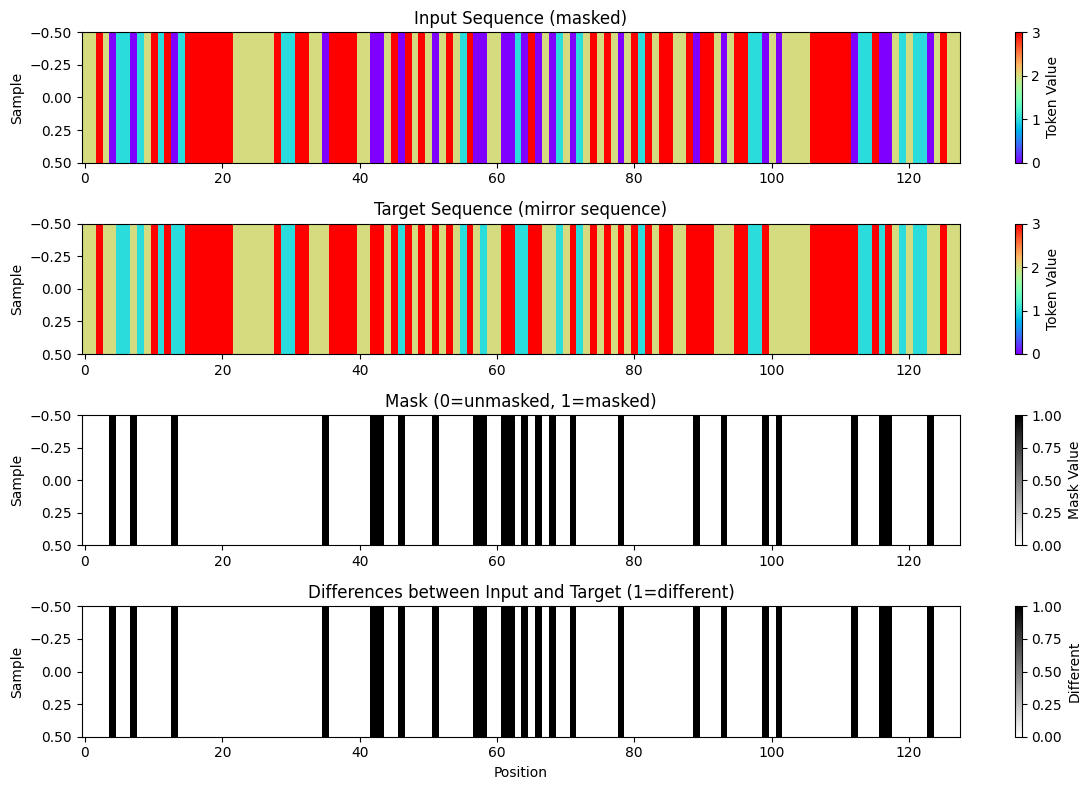

In [8]:
def visualize_masking(batch):
    # visualize the masking
    import matplotlib.pyplot as plt

    # Get a sample from the batch
    sample_idx = 0
    
    plt.figure(figsize=(12, 8))
    cmap = 'rainbow'
    max_val = batch['input'].max()
    
    # Plot 1: Input sequence
    plt.subplot(4, 1, 1)
    plt.title("Input Sequence (masked)")
    plt.imshow(batch['input'][sample_idx].cpu().numpy().reshape(1, -1), aspect='auto', cmap=cmap, vmin=0, vmax=max_val)
    plt.colorbar(label="Token Value")
    plt.ylabel("Sample")
    
    # Plot 2: Target sequence
    plt.subplot(4, 1, 2)
    plt.title("Target Sequence (mirror sequence)")
    plt.imshow(batch['target'][sample_idx].cpu().numpy().reshape(1, -1), aspect='auto', cmap=cmap, vmin=0, vmax=max_val)
    plt.colorbar(label="Token Value")
    plt.ylabel("Sample")
    
    # Plot 3: Mask (0=unmasked, 1=masked)
    plt.subplot(4, 1, 3)
    plt.title("Mask (0=unmasked, 1=masked)")
    plt.imshow(batch['mask'][sample_idx].cpu().numpy().reshape(1, -1), aspect='auto', cmap='binary')
    plt.colorbar(label="Mask Value")
    plt.ylabel("Sample")
    
    # Plot 4: Highlight differences between input and target
    diff = (batch['input'][sample_idx] != batch['target'][sample_idx]).cpu().numpy()
    plt.subplot(4, 1, 4)
    plt.title("Differences between Input and Target (1=different)")
    plt.imshow(diff.reshape(1, -1), aspect='auto', cmap='binary')
    plt.colorbar(label="Different")
    plt.ylabel("Sample")
    plt.xlabel("Position")
    plt.tight_layout()
    
    import os
    os.makedirs('results', exist_ok=True)
    plt.savefig("results/batch_masking_visualization.png")
    print("Saved batch masking visualization to batch_masking_visualization.png")
    
    return plt

visualize_masking(batch)